<a href="https://colab.research.google.com/github/neel-p8/Creating-an-Image-Mosaic/blob/main/Neel_Patel_3_the_majestic_mosaic_fall23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Majestic Mosaic

# The mosaic

The idea is to take an image -- and replace each pixel with a small image. The result will resemble a mosaic made of small colorful tiles.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from PIL import Image
import urllib.request
from keras.datasets import cifar100 as tiles_dataset

!pip install pycodestyle pycodestyle_magic
!pip install flake8
%load_ext pycodestyle_magic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 6.8 MB/s eta 0:00:00


# Data loading

In [ ]:
def get_image(img_URL, w):
  '''Downloads an image, resizes to size w x w and
    returns it as an np.array.
    Note that no normalization is performed.
  '''
  file_name = 'input_image_name_on_disk'
  urllib.request.urlretrieve(img_URL, file_name)
  im = Image.open(file_name)
  im = im.resize((w, w))
  return np.asarray(im)[..., :3] # removes a potential alpha channel

In [ ]:
img_UF_URL = "http://people.clas.ufl.edu/hwagner/files/UF.png"
img_ravenna_URL = "http://people.clas.ufl.edu/hwagner/files/ravenna.jpg"

# Can use another url; it must point directly at an image file
mos = get_image(img_UF_URL, w = 512)

In [ ]:
tiles = tiles_dataset.load_data()[0][0]

169001437/169001437 [==============================] - 4s 0us/step


# Task 1: Compute the mean colors of all the tiles and construct a kd-tree.

Generates 10 random colors and queries kd-tree for the nearest neighbours. For each of the 10 colors, shows original color, nearest mean color and the tile corresponding to the mean color.

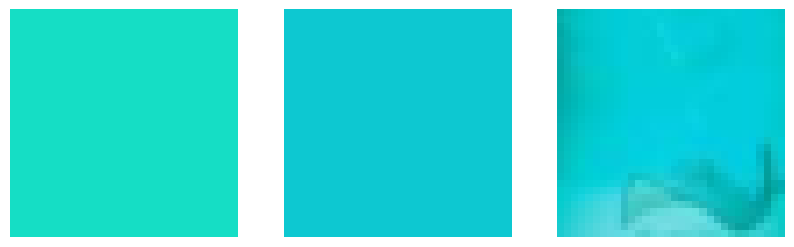

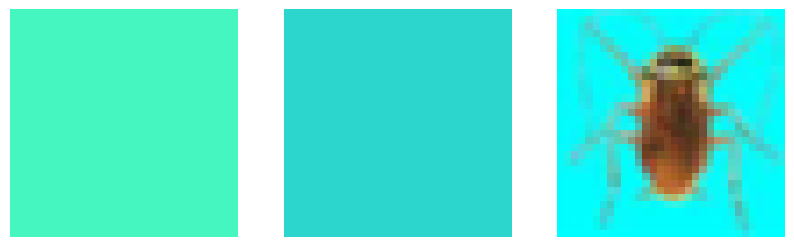

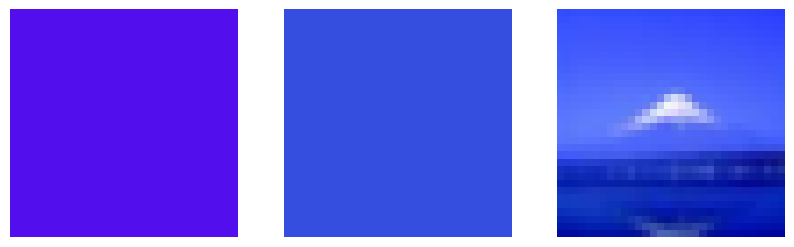

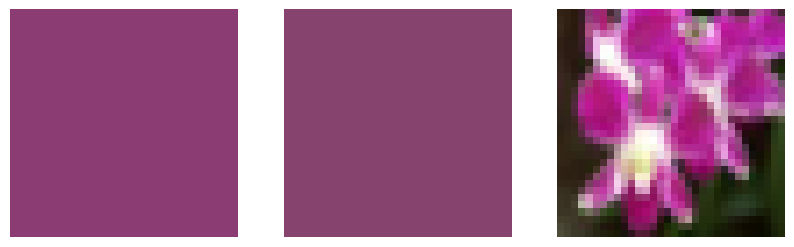

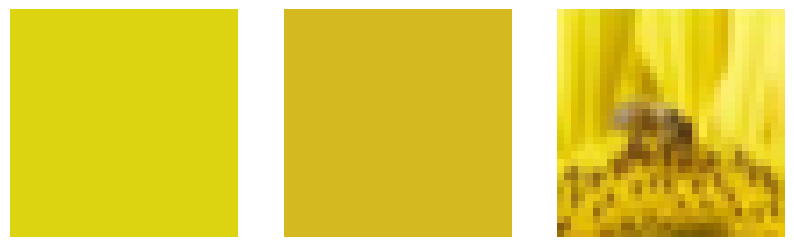

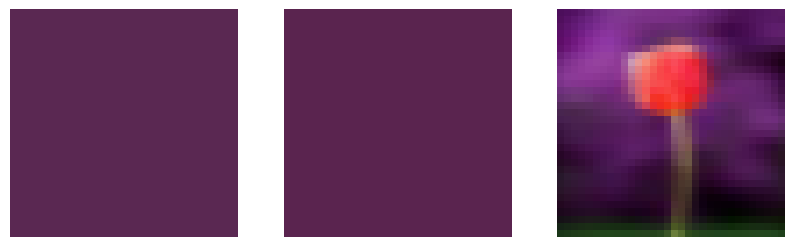

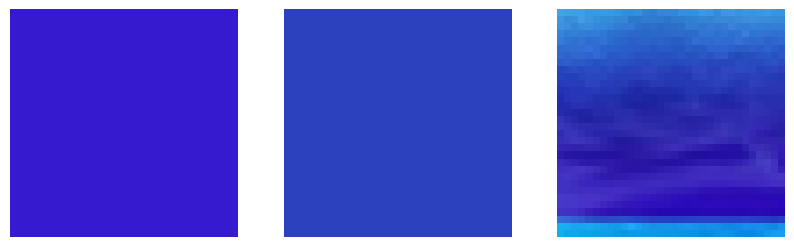

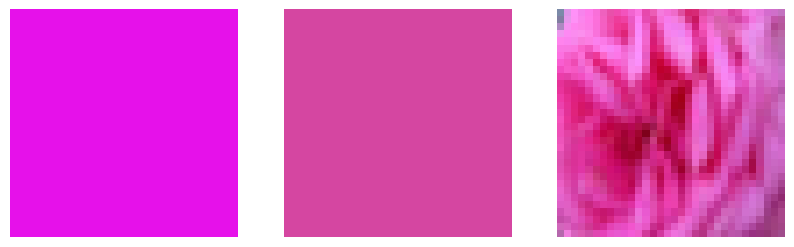

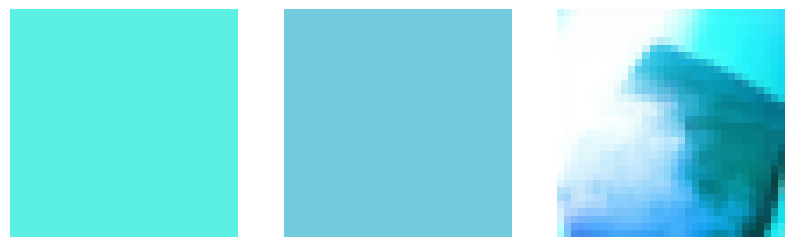

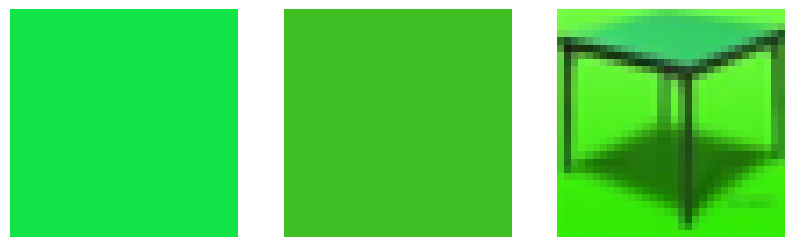

In [ ]:
#%%pycodestyle

def plot_images_in_a_row(ims):
    'Takes a list/array of images and plots them spaced horizontally.'

    # assert ims: list or numpyarray, elements in ims list or nparray
    # assert 3 dimensional images with 3 channels
    assert isinstance(ims, (list, np.ndarray))
    assert all(isinstance(im, np.ndarray) for im in ims)
    assert all(im.ndim == 3 for im in ims)
    assert all(im.shape[2] == 3 for im in ims)
    _, axs = plt.subplots(1, len(ims), figsize=(10, 5))
    for im, ax in zip(ims, axs.ravel()):
        if im.shape == (3,):  # If the image data is a single color
            im = im.reshape(1, 1, 3)  # Reshape it into a 3D array
        elif im.shape == (1, 32, 32, 3):  # If the image data is a tile
            im = np.squeeze(im)
        ax.imshow(im)
        ax.axis('off')


# compute the mean colors of all tiles
tile_mean = [np.mean(tile, axis=(0, 1)) for tile in tiles]

# construct kd-tree
kd_tree = KDTree(tile_mean)

# generate 10 random colors and query kd-tree for nearest neighbors
rand_colors = np.random.randint(0, 256, size=(10, 3))
distances, indice = kd_tree.query(rand_colors)

# write assert tests random color and tile means have appropriate shape
assert rand_colors.shape == (10, 3)
assert len(tile_mean) == len(tiles)

# plot 10 images and corresponding colors
for i in range(10):
    original_color = rand_colors[i].reshape(1, 1, 3)
    nearest_mean_color = tile_mean[indice[i][0]].reshape(1,
                                                         1, 3).astype(np.uint8)
    tile_corresponding = tiles[indice[i][0]]

    # test correct shape
    assert original_color.shape == (1, 1, 3)
    assert nearest_mean_color.shape == (1, 1, 3)
    assert tile_corresponding.shape == (32, 32, 3)

    plot_images_in_a_row([original_color, nearest_mean_color,
                          tile_corresponding])


# check query result length
def test_kd_tree_query():
    rand_colors = np.random.randint(0, 256, size=(10, 3))
    distances, indices = kd_tree.query(rand_colors)
    assert len(distances) == len(indices) == 10


test_kd_tree_query()


def test_synthetic_case():
    # synthetic color array
    synthetic_colors = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])

    # Query the kd-tree for nearest neighbors
    distances, indices = kd_tree.query(synthetic_colors, k=1)

    # Assert that the distances and indices have the correct shape
    assert distances.shape == (3, 1)
    assert indices.shape == (3, 1)


test_synthetic_case()

# Task 2: Implementation

In [ ]:
#%%pycodestyle

# reshape into 2D array
mos_reshape = mos.reshape(-1, 3)

# assert mos_reshape is numpy array
assert isinstance(mos_reshape, np.ndarray)

# query KD Tree based on reshape
distances_res, indice_res = kd_tree.query(mos_reshape)

# create empty numpy array of n image rows and columns
mosaic = np.empty((mos.shape[0] * 32, mos.shape[1] * 32, 3), dtype=np.uint8)

# mos_reshape has the correct shape
assert mos_reshape.shape == (mos.shape[0] * mos.shape[1], 3)

# mosaic has the correct shape
assert mosaic.shape == (mos.shape[0] * 32, mos.shape[1] * 32, 3)

# all indices are valid
assert np.all((indice_res >= 0) & (indice_res < len(tiles)))

# loop over each pixel, list coordinates for pixels, and count iterations
for index, (i, j) in enumerate(np.ndindex(mos.shape[:2])):

    # select corresponding tile to image pixel based on indice nearest neighbor
    tile = tiles[indice_res[index][0]]

    # assign tile to position in mosaic
    mosaic[i * 32: (i + 1) * 32, j * 32: (j + 1) * 32] = tile

# save as jpg, can switch to png if needed. uncomment if wanted
#Image.fromarray(mosaic).save('mosaic.jpg')

# Task 3: Validation

Imshow top left (8x8) portion of output image

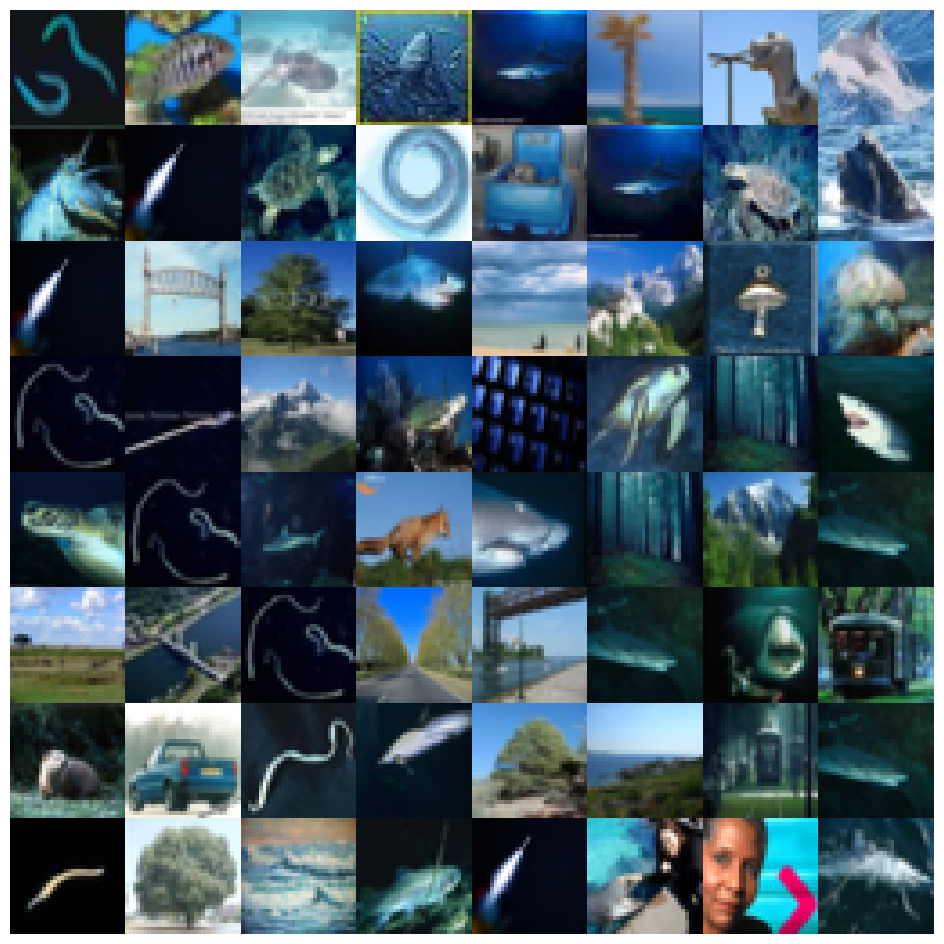

In [ ]:
#%%pycodestyle

# make output image bigger, output 8x8 tiles, multiply by 32 for correct size
plt.figure(figsize=(12, 12))
plt.imshow(mosaic[:8 * 32, :8 * 32])

# assert image size is correct
img = plt.gca().get_images()[0]
assert img.get_size() == (8 * 32, 8 * 32)

plt.axis('off')
plt.show()

# Attempt to Remove Tiles that Have Been Used Once Until All Used Once

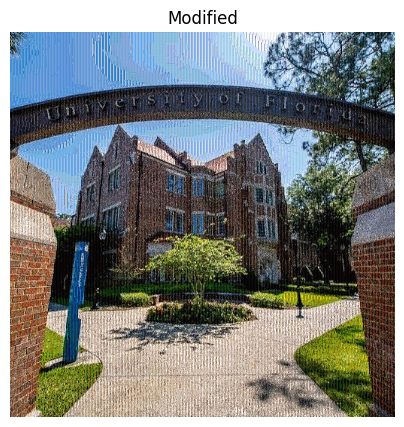

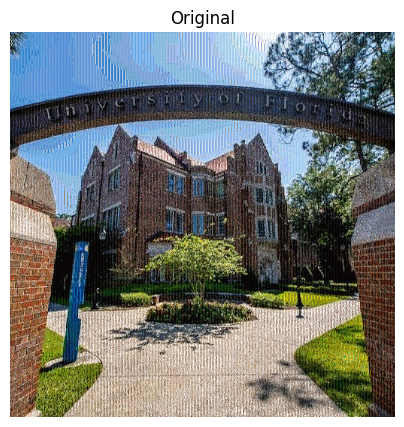

In [ ]:
# attempt to remove using tiles that have been used once until all used once
#%%pycodestyle

# empty set for used images
used_tiles = set()

# create another empty mosaic
mosaic_2 = np.empty((mos.shape[0] * 32, mos.shape[1] * 32, 3), dtype=np.uint8)

for index, (i, j) in enumerate(np.ndindex(mos.shape[:2])):

    # nearest tiles
    nearest_tiles = indice_res[index]

    # tiles not used
    for tile_index in nearest_tiles:
        if tile_index not in used_tiles:
            break

    # delete set of all used tiles
    if len(used_tiles) == len(tiles):
        used_tiles.clear()

    # add tile to set
    used_tiles.add(tile_index)

    # corresponding tile
    tile = tiles[tile_index]

    mosaic_2[i * 32: (i + 1) * 32, j * 32: (j + 1) * 32] = tile

# plot modified and original
plt.figure(figsize=(5, 5))
plt.title('Modified')
plt.imshow(mosaic_2)
plt.axis('off')

plt.figure(figsize=(5, 5))
plt.title('Original')
plt.imshow(mosaic)
plt.axis('off')

plt.show()